In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn import linear_model
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import Imputer, StandardScaler

In [2]:
df1 = pd.DataFrame(pd.read_csv('train.csv'))
df2 = pd.DataFrame(pd.read_csv('test.csv'))

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

df1['Sex'] = df1['Sex'].map({'female': 1, 'male': 0})
df1['Embarked'] = df1['Embarked'].map({'Q': 1, 'C': 0, 'S': 2})
imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
df1["Age"] = imp.fit_transform(df1[["Age"]]).ravel()
df1['Embarked'] = imp.fit_transform(df1[['Embarked']]).ravel()
df1.Embarked = df1.Embarked.astype(int)
df1.Age = df1.Age.astype(int)
df1['FamilySize'] = df1['SibSp'] + df1['Parch'] + 1
df1 = df1.assign(FamilySize = pd.Series(df1['FamilySize']))
df1['HasCabin'] = df1['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
df1['Name_length'] = df1['Name'].apply(len)

#df1['IsAlone'] = 0
#df1.loc[df1['FamilySize'] == 1, 'IsAlone'] = 1

df1['Single'] = df1['FamilySize'].map(lambda s: 1 if s == 1 else 0)
df1['SmallF'] = df1['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
df1['MedF'] = df1['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df1['LargeF'] = df1['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

df1['Title'] = df1['Name'].apply(get_title)
df1['Title'] = df1['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df1['Title'] = df1['Title'].replace('Mlle', 'Miss')
df1['Title'] = df1['Title'].replace('Ms', 'Miss')
df1['Title'] = df1['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df1['Title'] = df1['Title'].map(title_mapping)
df1['Title'] = df1['Title'].fillna(0)

#df1["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df1['Cabin'] ]) #zmapowac na inty
#df1['Cabin'] = df1['Cabin'].map({'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E': 1, 'F': 1, 'G': 1, 'T': 1})
df1 = df1.drop(columns = ['PassengerId', 'Cabin','Name', 'Ticket', 'Fare', 'Name_length'])
    
#============================================================================
    
df2['Sex'] = df2['Sex'].map({'female': 1, 'male': 0})
df2['Embarked'] = df2['Embarked'].map({'Q': 1, 'C': 0, 'S': 2})
imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
df2["Age"] = imp.fit_transform(df2[["Age"]]).ravel()
df2['Embarked'] = imp.fit_transform(df2[['Embarked']]).ravel()
df2.Embarked = df2.Embarked.astype(int)
df2.Age = df2.Age.astype(int)
df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1
df2 = df2.assign(FamilySize = pd.Series(df2['FamilySize']))    
df2['HasCabin'] = df2['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
df2['Name_length'] = df2['Name'].apply(len)

#df1['IsAlone'] = 0
#df1.loc[df1['FamilySize'] == 1, 'IsAlone'] = 1

df2['Single'] = df2['FamilySize'].map(lambda s: 1 if s == 1 else 0)
df2['SmallF'] = df2['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
df2['MedF'] = df2['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df2['LargeF'] = df2['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

df2['Title'] = df2['Name'].apply(get_title)
df2['Title'] = df2['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df2['Title'] = df2['Title'].replace('Mlle', 'Miss')
df2['Title'] = df2['Title'].replace('Ms', 'Miss')
df2['Title'] = df2['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df2['Title'] = df2['Title'].map(title_mapping)
df2['Title'] = df2['Title'].fillna(0)

#df2["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df2['Cabin'] ]) #zmapowac na inty
#df2['Cabin'] = df2['Cabin'].map({'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E': 1, 'F': 1, 'G': 1, 'T': 1})
df2 = df2.drop(columns = ['Name', 'Cabin', 'Ticket', 'Fare', 'Name_length'])

#print(df1)
#print(df2)

In [3]:
X = df1.drop('Survived', axis = 1)
y = df1['Survived']

skf = StratifiedKFold(n_splits = 4) #pobawic sie z iloscia splitow
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
    
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

y_predict = model.predict(X_test)
# for i in range(222):
#     if y_predict[i] >= 0.4:
#        y_predict[i] = 1
#     else:  
#        y_predict[i] = 0

# accuracy_score(y_test, y_predict)

In [4]:
#df2 = sc.transform(df2)
#y2_pred = clf.predict(df2)
#print(df2)

Xt = df2.drop(columns = ['PassengerId'])
yt = df2['PassengerId']

yt = yt.reset_index(drop=True)
yt = pd.DataFrame(np.array(yt).reshape(len(yt)), columns = ['PassengerId'])
#print(yt)

ytt = sc.transform(Xt)

yt2_predict = model.predict(ytt)

reg_pdict = pd.DataFrame({'reg': yt2_predict})
reg_pdict.to_csv('pdb-reg.csv', index = False)

#print(yt2_predict)

# for i in range(418):
#     if yt2_predict[i] >= 0.4:
#        yt2_predict[i] = 1
#     else:  
#        yt2_predict[i] = 0

#print(yt2_predict)
print(min(yt2_predict))
print(max(yt2_predict))   
    
df2t = pd.DataFrame(yt2_predict, columns = ['Survived'])
#print(df2t)

yt['Survived'] = df2t['Survived']
# yt.Survived = yt.Survived.astype(int)
# print(yt)

yt.to_csv('wynik-reg.csv', index = False)

-0.35458714684040893
1.1965738599281752


In [5]:
yt.Survived.value_counts()

0.121311    26
0.144630    12
0.666609    10
0.167948     7
0.108292     6
0.073575     5
0.335030     4
0.095273     4
0.103952     4
0.116971     3
0.090933     3
0.099613     3
0.228170     3
0.210812     3
0.643291     3
0.112642     3
0.634611     3
0.241189     2
0.442964     2
0.679628     2
0.747829     2
0.730993     2
0.374639     2
0.704309     2
0.125651     2
0.351831     2
0.638951     2
0.163608     2
0.197793     2
0.180434     2
            ..
0.023737     1
0.926807     1
0.959505     1
0.790649     1
0.213519     1
0.172288     1
1.093905     1
0.758829     1
0.338823     1
0.151689     1
0.865288     1
0.950877     1
0.888437     1
0.672028     1
0.055815     1
0.188014     1
0.884509     1
0.633419     1
0.990558     1
0.746214     1
0.855143     1
0.772112     1
0.513961     1
0.141910     1
0.173957     1
0.888595     1
0.703856     1
0.543558     1
0.236850     1
0.411487     1
Name: Survived, Length: 303, dtype: int64

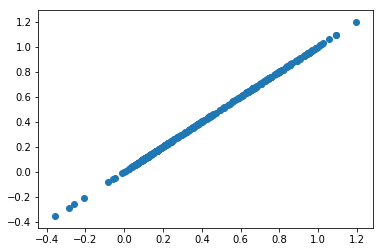

In [6]:
pt = df2['PassengerId']

#pt = pt.reset_index(drop=True)
#pt = pd.DataFrame(np.array(pt).reshape(len(pt)), columns = ['PassengerId'])

plt.scatter(yt2_predict,yt2_predict)


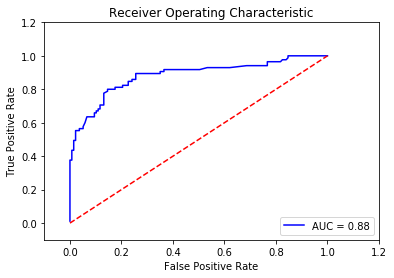

In [7]:
actual = y_test #df1['Survived']
predictions = y_predict #df2t

#print(actual)
#print(predictions)

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()